In [45]:
! pip install kaggle
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"sayansh001","key":"bb83f534024ea023f7468a775ff3e4f2"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d arpitjain007/dog-vs-cat-fastai

mkdir: cannot create directory ‘/root/.kaggle’: File exists
dog-vs-cat-fastai.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip /content/dog-vs-cat-fastai.zip

Archive:  /content/dog-vs-cat-fastai.zip
replace dogscats/dogscats/sample/train/cats/cat.11737.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
import random
from keras.preprocessing.image import load_img

In [47]:
data = []
label = []

for class_name in os.listdir("/content/dogscats/dogscats/train"):
    for path in os.listdir("/content/dogscats/dogscats/train/"+class_name):
        if class_name == 'cats':
            label.append(0)
        else:
            label.append(1)
        data.append(os.path.join("/content/dogscats/dogscats/train", class_name, path))
print(data[0], label[0])

/content/dogscats/dogscats/train/dogs/dog.7487.jpg 1


In [48]:
print(data[845],label[845])

/content/dogscats/dogscats/train/dogs/dog.5124.jpg 1


In [49]:
len(data)

23000

In [50]:
df = pd.DataFrame()
df['images']=data
df['label']=label
df = df.sample(frac=1).reset_index(drop=True)
#frac = 1 ensures that it will return all rows
df.head()

images  label
0  /content/dogscats/dogscats/train/dogs/dog.5479...      1
1  /content/dogscats/dogscats/train/cats/cat.1329...      0
2  /content/dogscats/dogscats/train/cats/cat.5705...      0
3  /content/dogscats/dogscats/train/dogs/dog.9893...      1
4  /content/dogscats/dogscats/train/dogs/dog.1191...      1

In [51]:
for i in df['images']:
    if '.jpg' not in i:
        print(i)

In [52]:
import PIL
l = []
for image in df['images']:
    try:
        img = PIL.Image.open(image)
    except:
        l.append(image)
l

[]

In [53]:
# delete db files
df = df[df['images']!='PetImages/Dog/Thumbs.db']
df = df[df['images']!='PetImages/Cat/Thumbs.db']
df = df[df['images']!='PetImages/Cat/666.jpg']
df = df[df['images']!='PetImages/Dog/11702.jpg']
len(df)

23000

Exploratory Data Analysis

To display grid of images

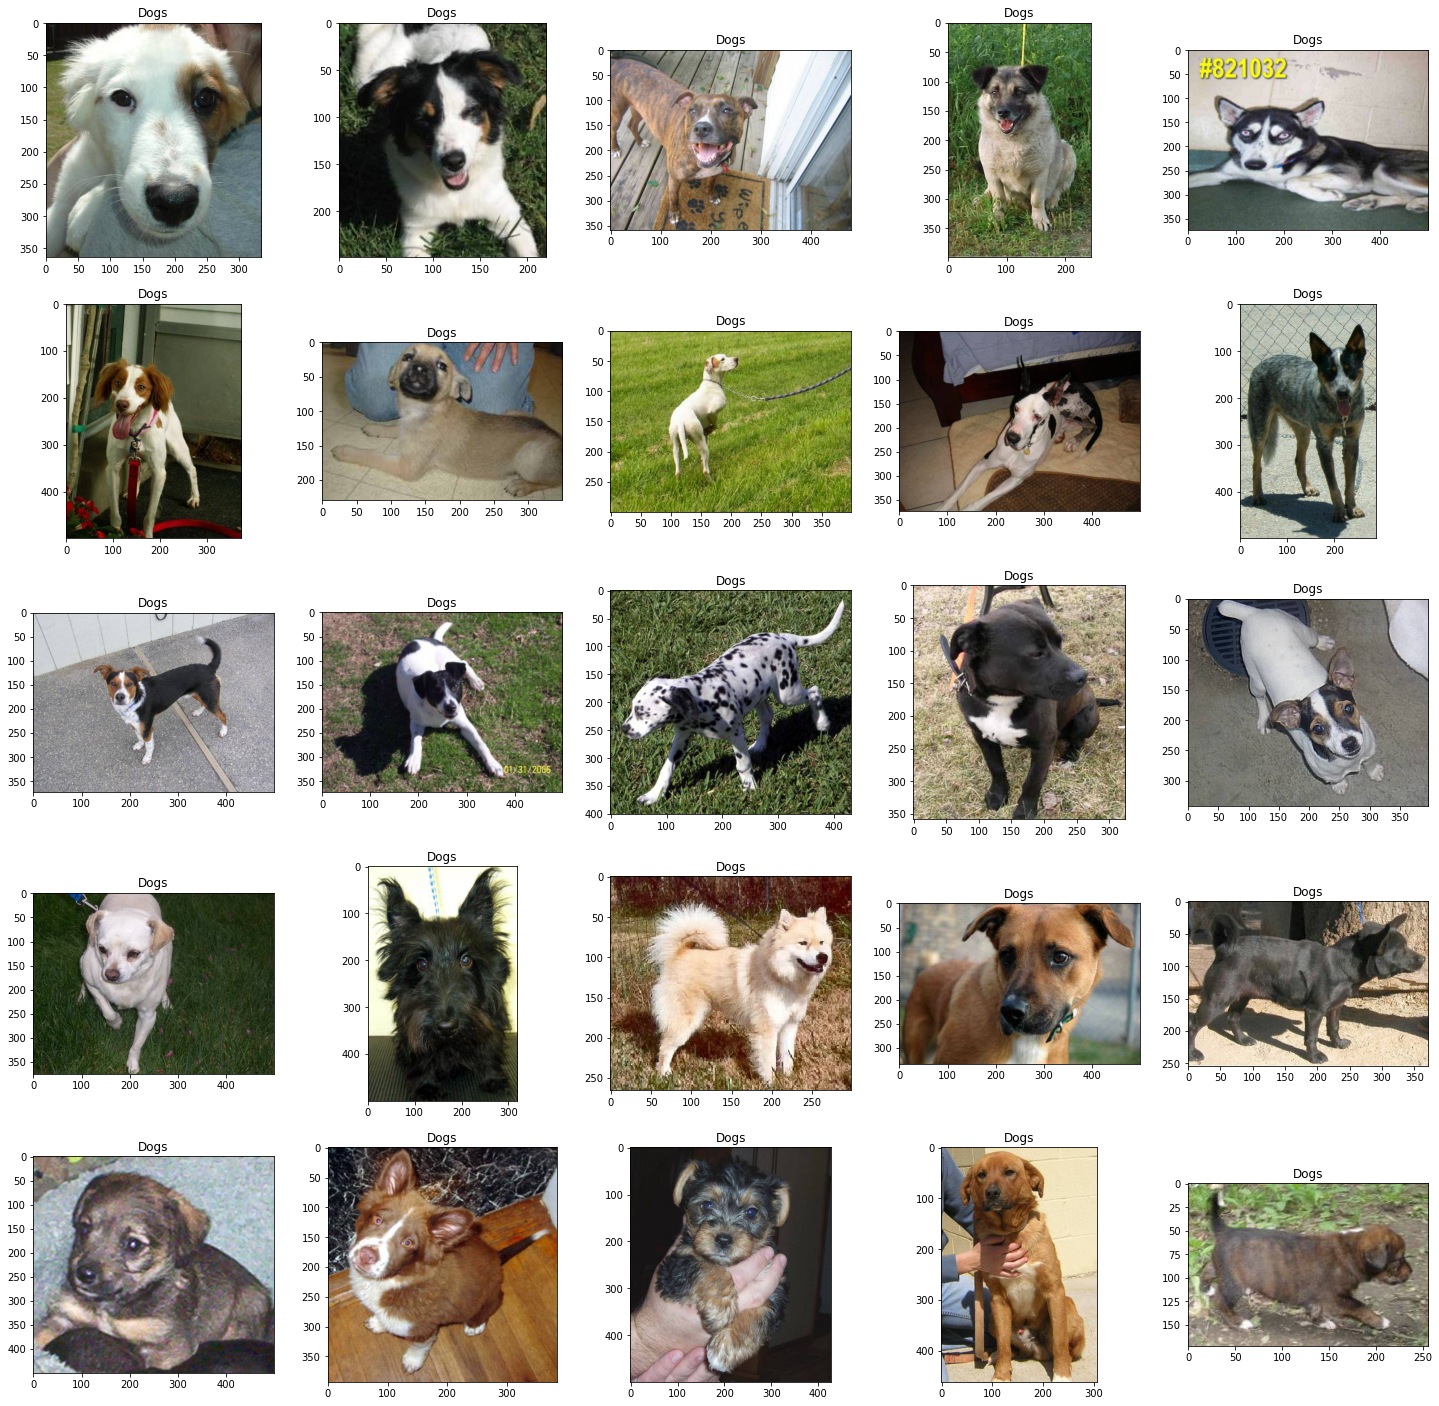

In [54]:
plt.figure(figsize=(25,25))
temp = df[df['label']==1]['images']  #all the images of dogs will be stored in temp
start = random.randint(0,len(temp))  #this generates a random number between 0 and len(temp)
files = temp[start:start+25]         #in files we store the first 25 continuous images between the random number generated 
                                     #since temp is basically images of dogs from step 2
for index,file in enumerate(files):
  plt.subplot(5,5,index+1)
  img = load_img(file)
  img = np.array(img)
  plt.imshow(img)
  plt.imshow(img)
  plt.title('Dogs')
  plt.axis()

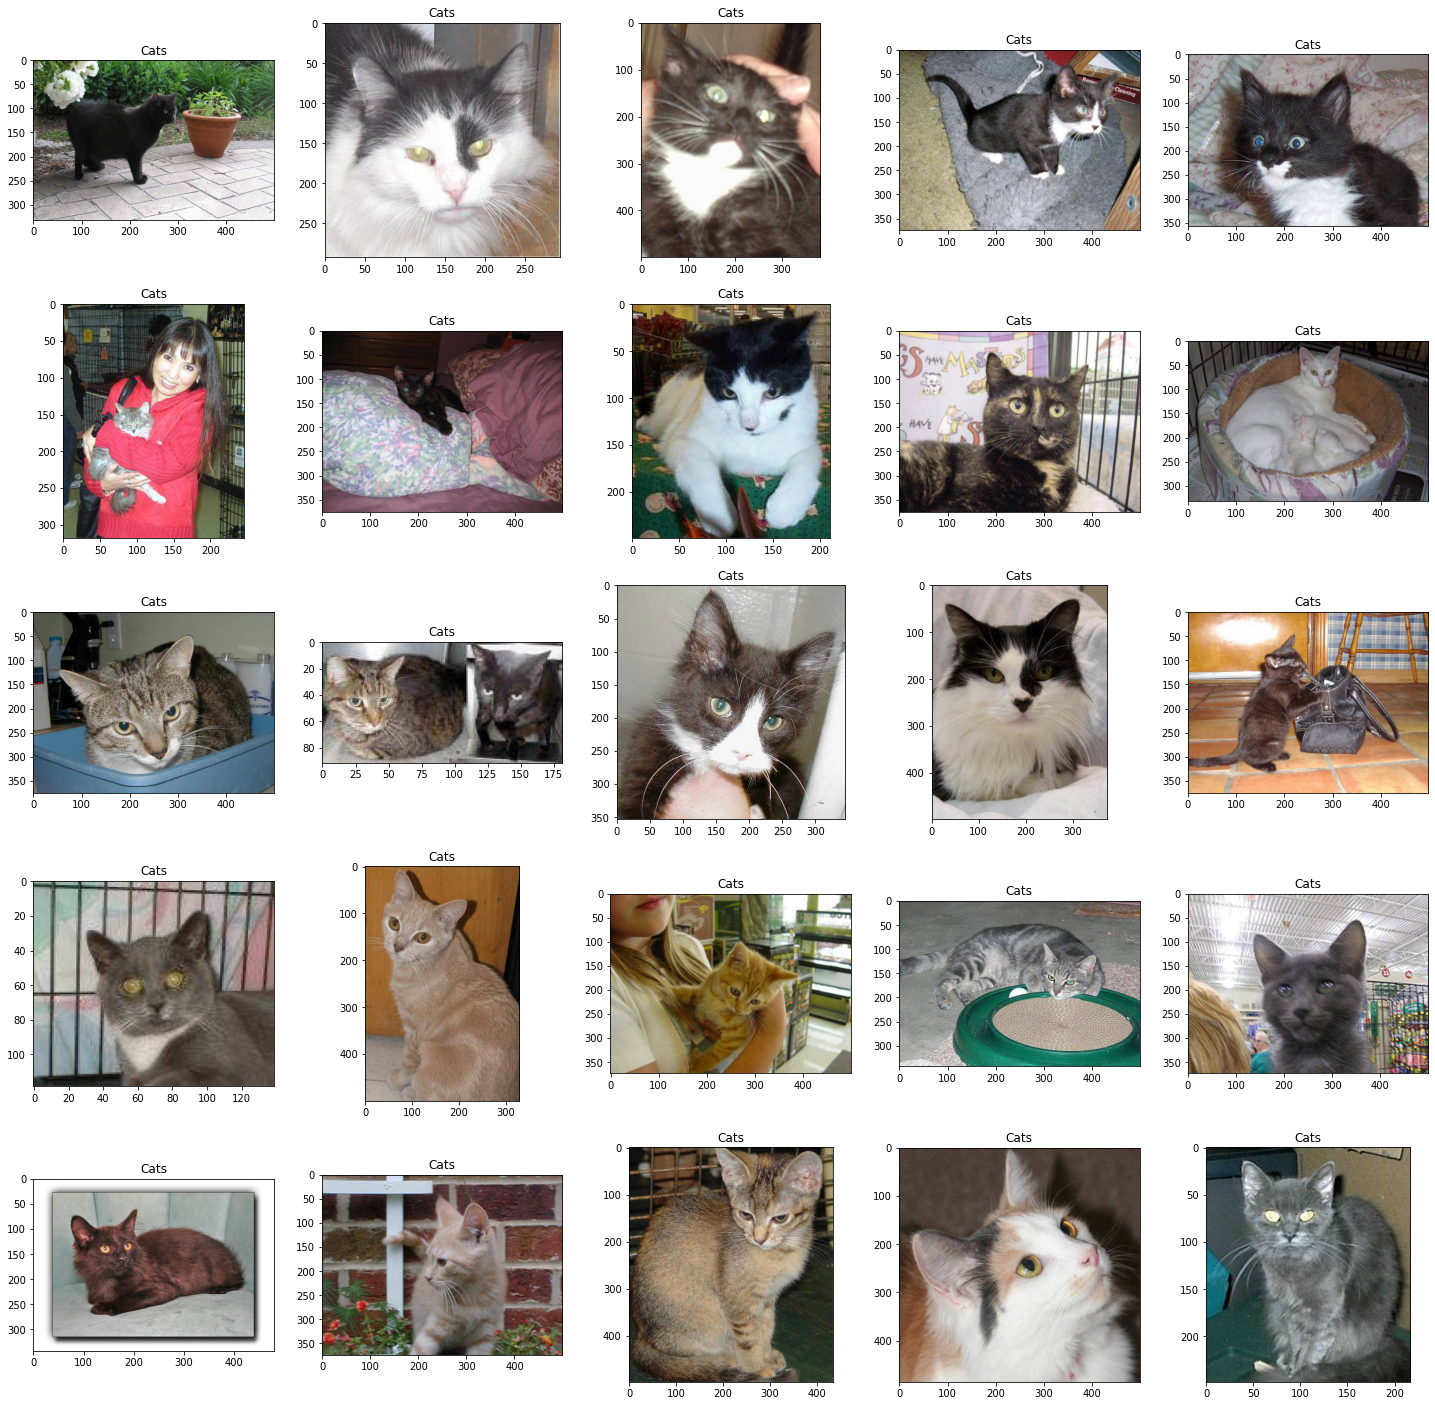

In [55]:
plt.figure(figsize=(25,25))
temp = df[df['label']==0]['images']  #all the images of dogs will be stored in temp
start = random.randint(0,len(temp))  #this generates a random number between 0 and len(temp)
files = temp[start:start+25]         #in files we store the first 25 continuous images between the random number generated 
                                     #since temp is basically images of dogs from step 2
for index,file in enumerate(files):
  plt.subplot(5,5,index+1)
  img = load_img(file)
  img = np.array(img)
  plt.imshow(img)
  plt.imshow(img)
  plt.title('Cats')
  plt.axis()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


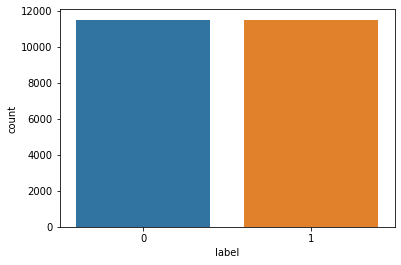

In [56]:
import seaborn as sns
sns.countplot(df['label'])

Create Data Generator for the Images

In [57]:
df['label'] = df['label'].astype('str')

In [58]:
from sklearn.model_selection import train_test_split
train,test = train_test_split(df,test_size=0.2,random_state=42)

In [67]:
from keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(
    rescale=1./255,   #Normalising the images to bring it between 0 and 1,easier for images to be processed
    #Augmentation purposes done to prevent overfitting
    rotation_range = 40,    
    shear_range = 0.2,         #it will slant the image
    zoom_range = 0.2,
    horizontal_flip = True,    #generate mirror image
    fill_mode = 'nearest'
)
val_generator = ImageDataGenerator(rescale=1./255)

#for loading the images 
train_iterator = train_generator.flow_from_dataframe(train,
                                                     x_col='images',
                                                     y_col='label',
                                                     target_size=(128,128),
                                                     batch_size=512,
                                                     class_mode='binary')

val_iterator = val_generator.flow_from_dataframe(test,
                                                     x_col='images',
                                                     y_col='label',
                                                     target_size=(128,128),
                                                     batch_size=512,
                                                     class_mode='binary')

Found 18400 validated image filenames belonging to 2 classes.
Found 4600 validated image filenames belonging to 2 classes.


Model Creation and Training

In [68]:
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense

model = Sequential([
                    Conv2D(16,(3,3),activation='relu',input_shape=(128,128,3)),
                    MaxPool2D((2,2)),
                    Conv2D(32,(3,3),activation='relu'),
                    MaxPool2D((2,2)),
                    Conv2D(64,(3,3),activation='relu'),
                    MaxPool2D((2,2)),
                    Flatten(),
                    Dense(512,activation='relu'),
                    Dense(1,activation='sigmoid')
                   ])

In [69]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 63, 63, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 30, 30, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 14, 14, 64)      

In [71]:
history = model.fit(train_iterator, epochs=10, validation_data=val_iterator)

Epoch 1/10
36/36 [==============================] - 135s 4s/step - loss: 0.7316 - accuracy: 0.5287 - val_loss: 0.6600 - val_accuracy: 0.6383
Epoch 2/10
36/36 [==============================] - 134s 4s/step - loss: 0.6450 - accuracy: 0.6240 - val_loss: 0.6260 - val_accuracy: 0.6439
Epoch 3/10
36/36 [==============================] - 131s 4s/step - loss: 0.5885 - accuracy: 0.6864 - val_loss: 0.5582 - val_accuracy: 0.7080
Epoch 4/10
36/36 [==============================] - 131s 4s/step - loss: 0.5630 - accuracy: 0.7073 - val_loss: 0.5463 - val_accuracy: 0.7204
Epoch 5/10
36/36 [==============================] - 131s 4s/step - loss: 0.5341 - accuracy: 0.7324 - val_loss: 0.5047 - val_accuracy: 0.7526
Epoch 6/10
36/36 [==============================] - 131s 4s/step - loss: 0.5124 - accuracy: 0.7462 - val_loss: 0.4877 - val_accuracy: 0.7596
Epoch 7/10
36/36 [==============================] - 134s 4s/step - loss: 0.4930 - accuracy: 0.7605 - val_loss: 0.5079 - val_accuracy: 0.7524
Epoch 8/10
36

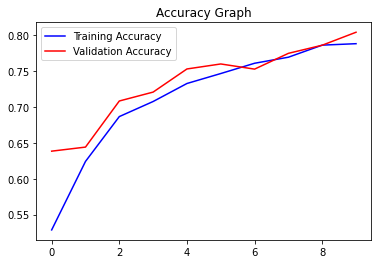

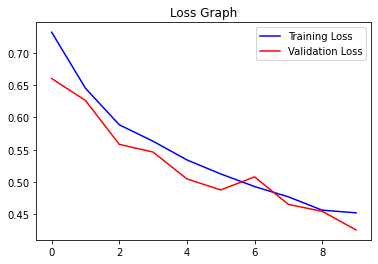

In [72]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

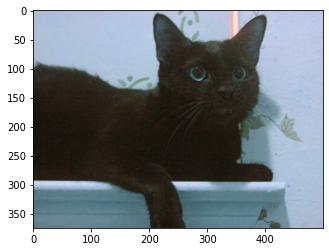

In [103]:
import cv2 
img=cv2.imread(r"/content/dogscats/sample/train/cats/cat.11737.jpg")
plt.imshow(img)
plt.show()

In [110]:
import numpy as np
from keras.preprocessing import image
test_image = image.load_img(r"/content/dogscats/sample/train/cats/cat.11737.jpg", target_size = (128, 128))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
train_iterator.class_indices
if result[0][0] == 1:
  prediction = 'dog'
else:
  prediction = 'cat'
print(prediction)

cat


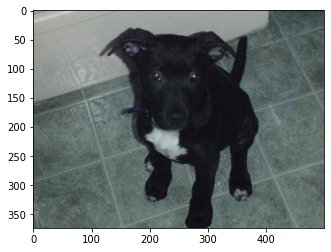

In [111]:
import cv2 
img=cv2.imread(r"/content/dogscats/sample/train/dogs/dog.9077.jpg")
plt.imshow(img)
plt.show()

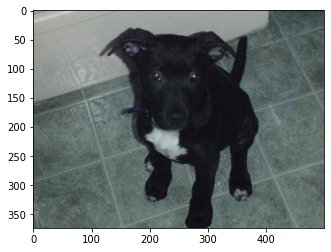

In [100]:
import cv2 
img=cv2.imread(r"/content/dogscats/sample/train/dogs/dog.9077.jpg")
plt.imshow(img)
plt.show()

In [109]:
import numpy as np
from keras.preprocessing import image
test_image = image.load_img(r"/content/dogscats/sample/train/dogs/dog.9077.jpg", target_size = (128, 128))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
train_iterator.class_indices
if result[0][0] == 1:
  prediction = 'dog'
else:
  prediction = 'cat'
print(prediction)

cat
